In [1]:
import os
os.chdir('../')

In [2]:
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score
from src.utils import flatten, get_segments
from src.segmentation import ImobsSegmentation

In [3]:
df_preds = (
    pd.read_csv("notebooks/outputs/df_preds.csv")
    .rename(columns={ "dt_calendar": "dt_ativacao"})
)
df_preds["dt_ativacao"] = pd.to_datetime(df_preds["dt_ativacao"]).dt.strftime("%Y-%m")

df_preds.head()

,dt_ativacao,id_imobiliaria,predictions,target,old_segments
0,2022-01,38,0.033534,0,B
1,2022-01,50,0.033887,0,B
2,2022-01,63,0.031284,0,A
3,2022-01,81,0.135855,0,E
4,2022-01,95,0.097252,0,E


In [4]:
partitioner = ImobsSegmentation()
partitioner.fit(df_preds)

OptimalBinning(gamma=0.5, max_n_bins=3, name='score_imobiliaria', solver='mip')

In [5]:
print(f"Splits: {partitioner.splits}")
partitioner.binning_table()

Splits: [0.03395527 0.05592736]


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.03)",1103,0.482502,1101,2,0.001813,2.379893,1.060539,0.108112
1,"[0.03, 0.06)",717,0.313648,701,16,0.022315,-0.151015,0.007697,0.000961
2,"[0.06, inf)",466,0.203850,440,26,0.055794,-1.102256,0.435012,0.051781
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,2286,1.000000,2242,44,0.019248,,1.503248,0.160854


In [6]:
df_preds = partitioner.get_optimal_segments(df_preds)

df_preds["old_transformed_segments"] = (
    df_preds["old_segments"]
    .replace(['B', 'C', 'D'],'B')
    .replace('E', 'C')
)

df_preds.head()

,dt_ativacao,id_imobiliaria,predictions,target,old_segments,optimal_bins,optimal_segments,old_transformed_segments
0,2022-01,38,0.033534,0,B,0.001813,1-baixo,B
1,2022-01,50,0.033887,0,B,0.001813,1-baixo,B
2,2022-01,63,0.031284,0,A,0.001813,1-baixo,A
3,2022-01,81,0.135855,0,E,0.055794,3-alto,C
4,2022-01,95,0.097252,0,E,0.055794,3-alto,C


In [7]:
df_preds.to_csv(f"notebooks/outputs/df_bins.csv", index=False)

In [8]:
# Segmentação ótima
partitioner.calculate_auc_among_segments(df_preds)
partitioner.calculate_auc_within_segments(df_preds, "optimal_bins")

AUC among segments:               
- Optimal segments: 0.78

AUC within segments (mean): 0.502


,rating,auc
0,0.001813,0.522
1,0.022315,0.470
2,0.055794,0.513


In [8]:
# Segmentação antiga
partitioner.calculate_auc_among_segments(df_preds, "old_segments")
partitioner.calculate_auc_within_segments(df_preds, "old_segments")

AUC among segments:               
- Optimal segments: 0.78
- Alternative segments: 0.758

AUC within segments (mean): 0.64


,rating,auc
0,A,0.483
1,B,0.798
2,C,0.799
3,D,0.524
4,E,0.596


In [9]:
# Segmentação antiga considerando ratings B-C-D como um único
partitioner.calculate_auc_among_segments(df_preds, "old_transformed_segments")
partitioner.calculate_auc_within_segments(df_preds, "old_transformed_segments")

AUC among segments:               
- Optimal segments: 0.78
- Alternative segments: 0.698

AUC within segments (mean): 0.62


,rating,auc
0,A,0.483
1,B,0.780
2,C,0.596


In [10]:
df_preds.groupby(["old_transformed_segments"])["target"].mean()

old_transformed_segments
A    0.002899
B    0.012364
C    0.045936
Name: target, dtype: float64

In [11]:
df_preds.groupby(["optimal_bins", "optimal_segments"])["target"].mean()

optimal_bins  optimal_segments
0.001813      baixo               0.001813
0.022315      medio               0.022315
0.055794      alto                0.055794
Name: target, dtype: float64

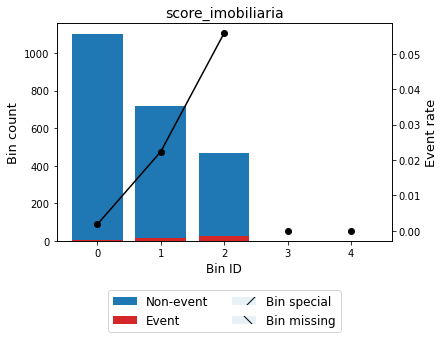

In [12]:
partitioner.binning_table(mode="plot")

In [13]:
partitioner.binning_table(mode="analysis")

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.55901792
    IV (Jeffrey)             1.50324812
    JS (Jensen-Shannon)      0.16085394
    Hellinger                0.17286450
    Triangular               0.57182704
    KS                       0.44562485
    HHI                      0.37273824
    HHI (normalized)         0.21592280
    Cramer's V               0.14949509
    Quality score            0.00360430

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic  p-value  P[A > B]  P[B > A]
        0      1    18.652187 0.000016  0.000002  0.999998
        1      2     9.244733 0.002362  0.001106  0.998894



/Users/raquel.camara/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
